In [1]:
import numpy as np
from scipy.io import wavfile
import math
import glob
import os
import matplotlib.pyplot as plt

### Note frequencies

In [2]:
note_freqs = {
    329.63: 'E1',
    246.94: 'B2',
    196.00: 'G3',
    146.83: 'D4',
    110.00: 'A5',
    82.41: 'E6'
}
freq_list = list(note_freqs.keys())

### Estimation

In [3]:
def estimate_fundamental(filename):
    # autocorrelation for pitch estimation
    fs, y = wavfile.read(filename)
    if y.ndim == 2:
        y = y.mean(axis=1)  # average channels if stereo
    y = y.astype(np.float64)
    
    # only first 1 sec
    max_samples = fs * 1
    y = y[:max_samples]
    
    # autocorrelation
    corr = np.correlate(y, y, mode='full')
    corr = corr[len(corr)//2:]
    
    # normlize
    corr = corr / (corr[0] + 1e-10)
    
    # lag range based on expected frequencies (50-400 Hz)
    min_lag = int(fs / 400)
    max_lag = int(fs / 50)
    
    if max_lag > len(corr):
        max_lag = len(corr)
    
    corr_segment = corr[min_lag:max_lag]
    if len(corr_segment) == 0:
        raise ValueError("no valid lag range")
    
    # f the peak in the segment
    peak_lag = np.argmax(corr_segment) + min_lag
    if peak_lag == 0:
        raise ValueError("no peak found")
    
    freq_est = fs / peak_lag
    
    # parabolic interpolation around peak
    if 1 <= peak_lag < len(corr) - 1:
        a = corr[peak_lag - 1]
        b = corr[peak_lag]
        c = corr[peak_lag + 1]
        denom = a - 2 * b + c
        if denom != 0:
            delta = 0.5 * (a - c) / denom
            peak_lag += delta
        freq_est = fs / peak_lag
    
    return freq_est

### Visualizations

In [4]:
def plot_signal_and_spectrum(filename, f_est):
    fs, y = wavfile.read(filename)
    if y.ndim == 2:
        y = y[:, 0]  # left channel if stereo
    y = y.astype(np.float64)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    t = np.arange(len(y)) / fs
    plt.plot(t, y)
    plt.title(f'waveform - {os.path.basename(filename)}')
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    
    # spectral analysis with FFT
    N = len(y)
    fft = np.fft.fft(y)
    mag = np.abs(fft[:N//2])
    freq = np.fft.fftfreq(N, 1/fs)[:N//2]
    
    plt.subplot(2, 1, 2)
    plt.plot(freq, 20 * np.log10(mag + 1e-10))
    plt.xlim(0, 1000)  # focus on lower frequencies
    plt.axvline(f_est, color='r', linestyle='--', label=f'estimated: {f_est:.2f} Hz')
    plt.title('magnitude spectrum')
    plt.xlabel('frequency (Hz)')
    plt.ylabel('magnitude (dB)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

def determine_note_and_cents(f_measured):
    # closest standard frequency
    closest_idx = np.argmin([abs(f_measured - f) for f in freq_list])
    f_standard = freq_list[closest_idx]
    note = note_freqs[f_standard]
    
    # cents deviation
    if f_measured > 0 and f_standard > 0:
        cents = 1200 * math.log2(f_measured / f_standard)
    else:
        cents = 0.0
    
    return note, cents

file: ../data/music.wav
note: A5
accuracy: 88.19 cents


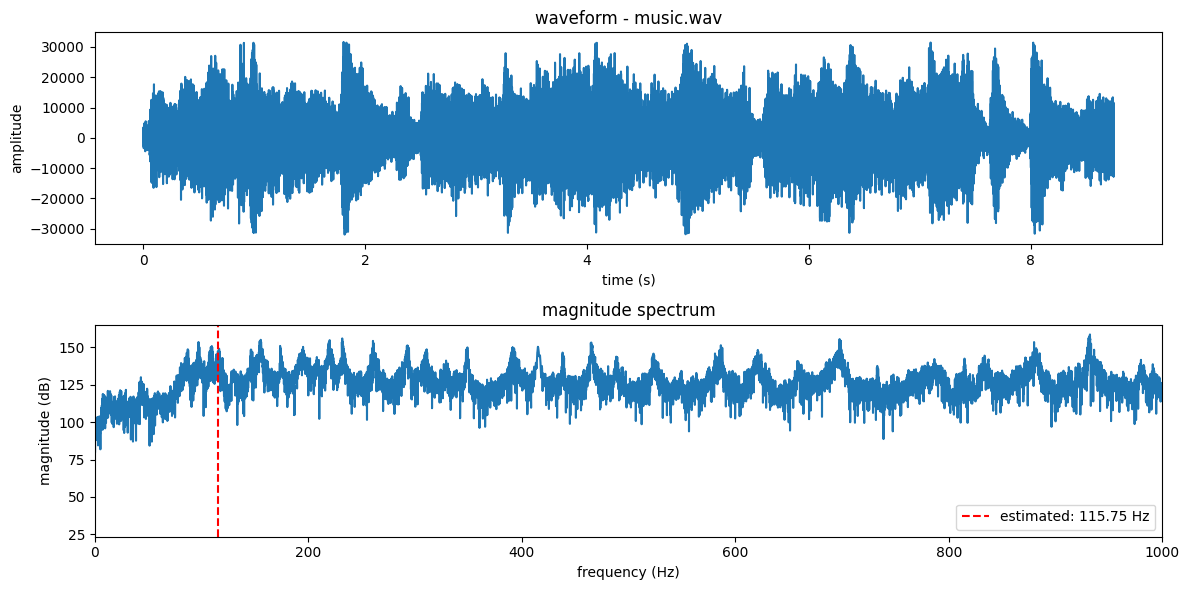

---
file: ../data/noise1.wav
note: E6
accuracy: -416.21 cents


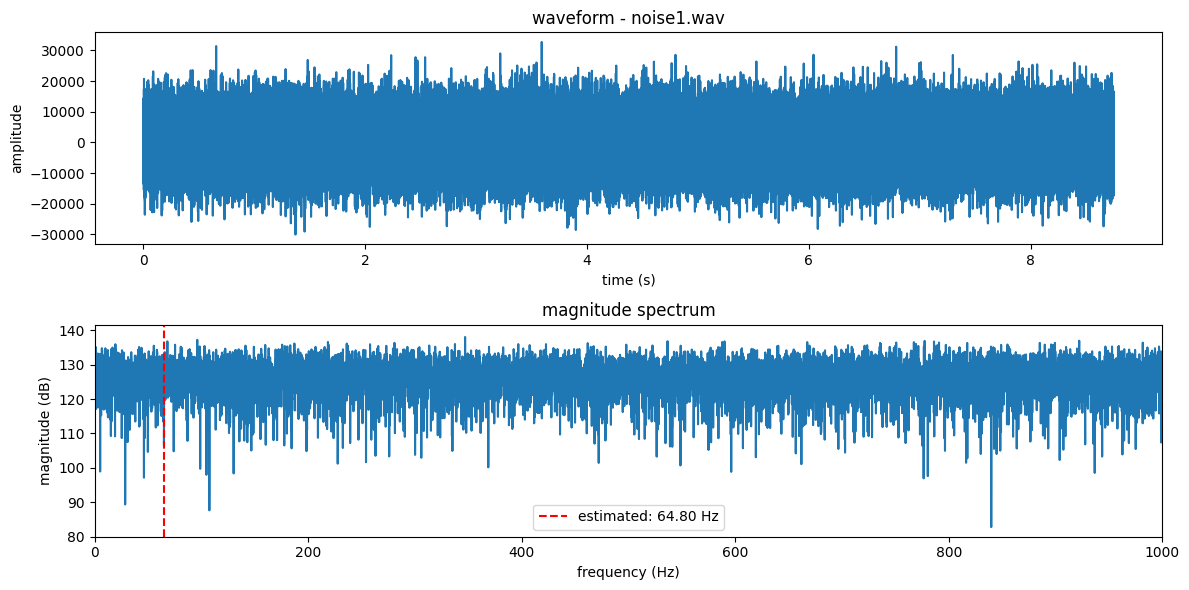

---
file: ../data/noise2.wav
note: E1
accuracy: 403.41 cents


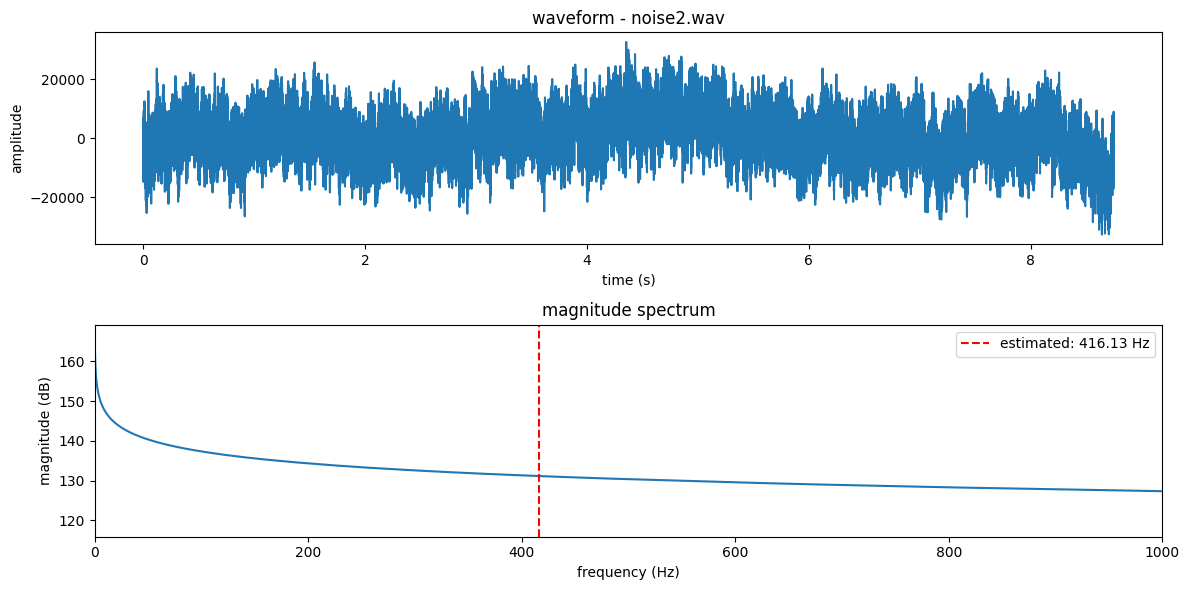

---
file: ../data/noise3.wav
note: E1
accuracy: 276.14 cents


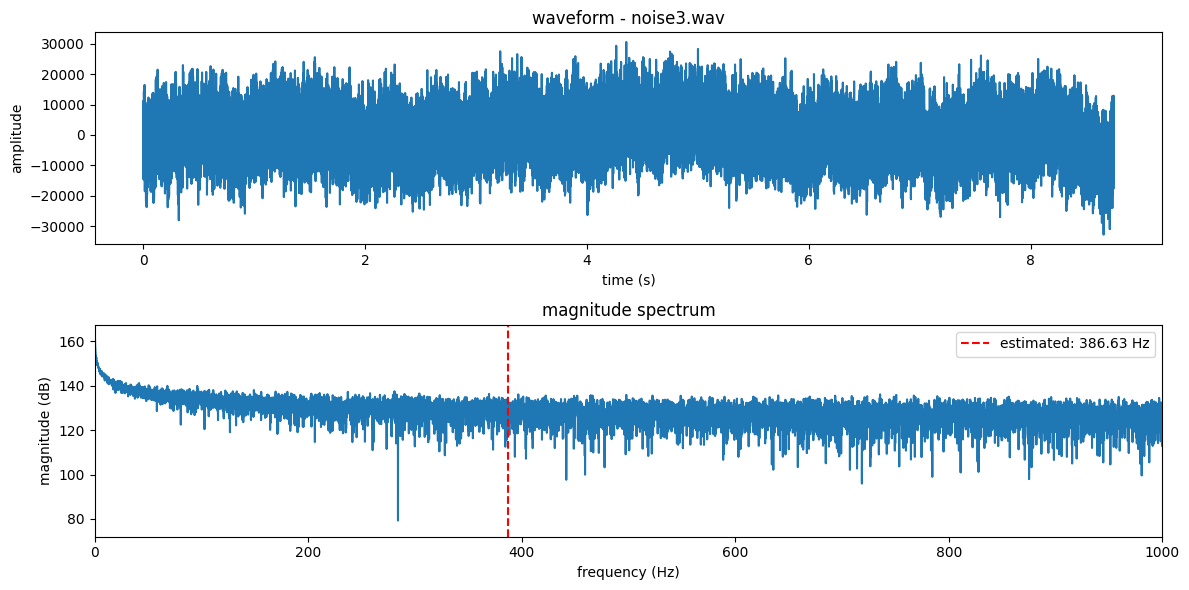

---
file: ../data/string_1.wav
note: E1
accuracy: 284.51 cents


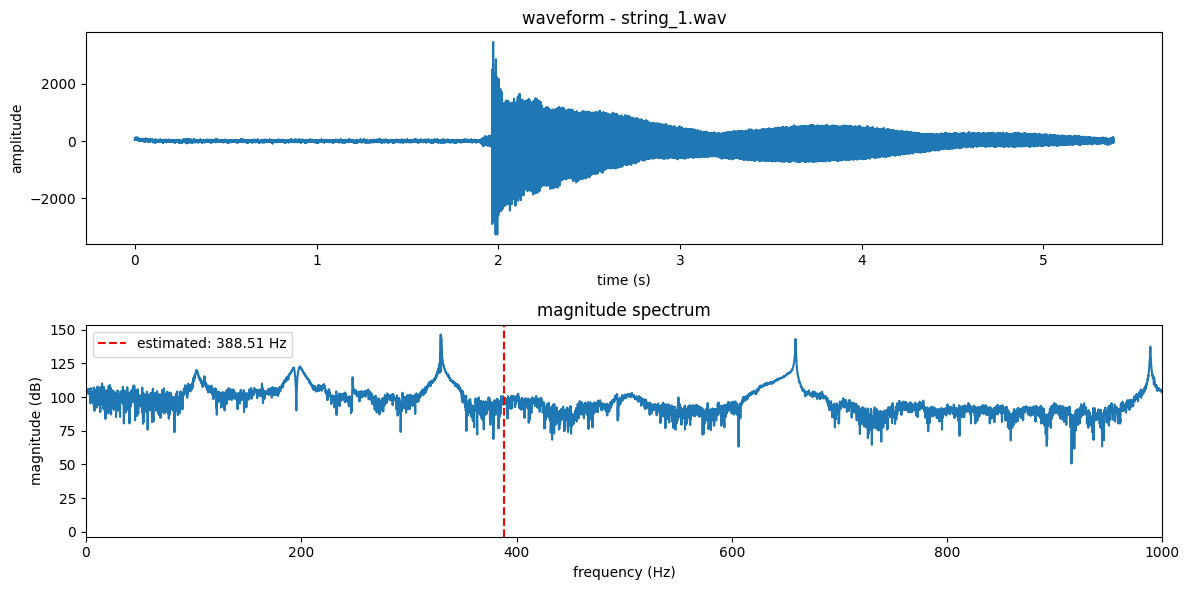

---
file: ../data/string_2.wav
note: E1
accuracy: 428.77 cents


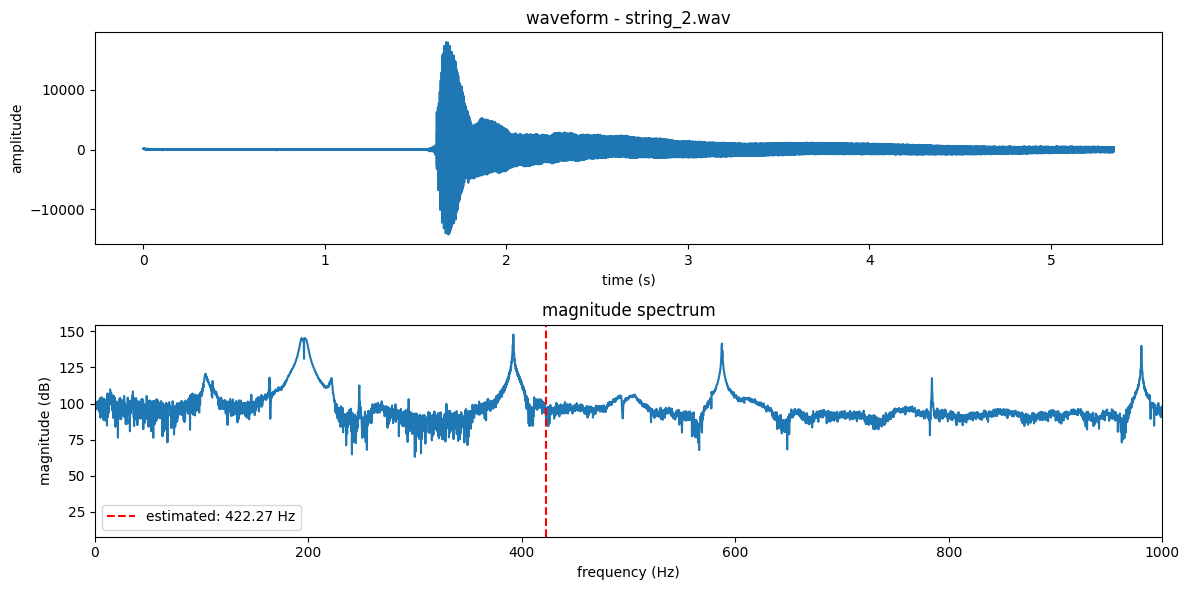

---
file: ../data/string_3.wav
note: E1
accuracy: 277.35 cents


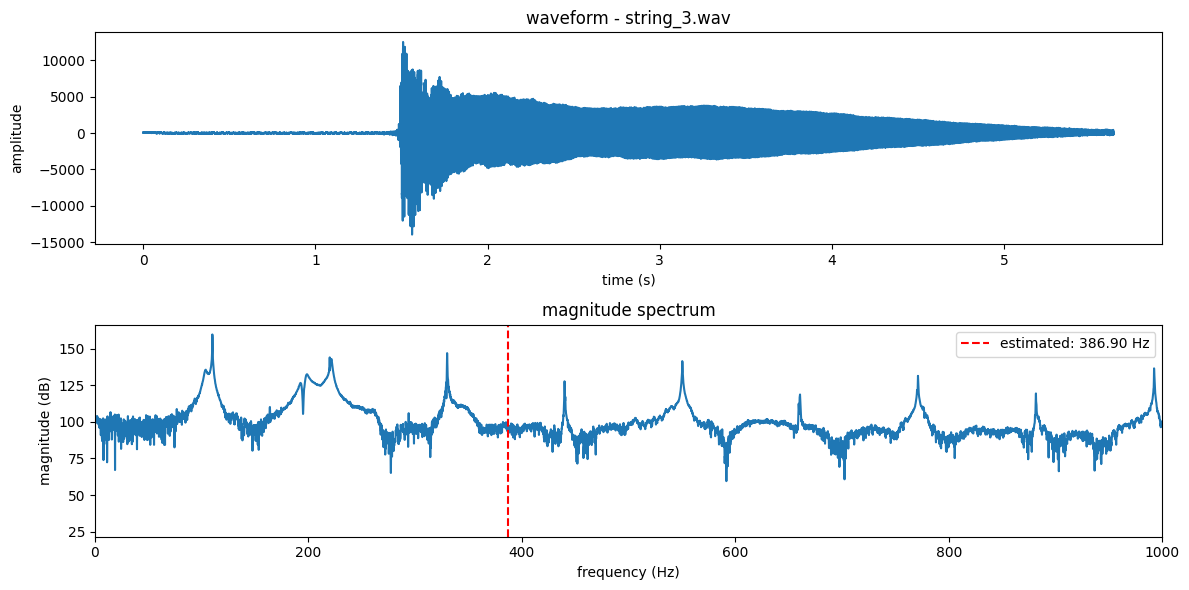

---


In [5]:
wav_files = glob.glob('../data/*.wav')

for filename in sorted(wav_files):
    try:
        f_measured = estimate_fundamental(filename)
        note, cents = determine_note_and_cents(f_measured)
        print(f"file: {filename}")
        print(f"note: {note}")
        print(f"accuracy: {cents:.2f} cents")
        plot_signal_and_spectrum(filename, f_measured)
        print("---")
    except Exception as e:
        print(f"error for file {filename}: {e}")